# Chapter 4 Deep Recurrent Model Architectures

In this chapter, we will expand on the recurrent model.

We will discuss a class of neural networks that can model sequences where X (or y) is not just a single independent data point, but a temporal sequence of data points [X1, X2, .. Xt] (or [y1, y2, .. yt]).

Such networks are classified as Recurrent Neural Networks (RNNs). These networks are capable of modeling the temporal aspect of data by including additional weights in the model that create cycles in the network. This helps maintain a state, as shown in the following diagram:

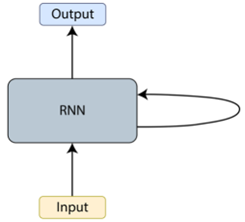

This chapter covers the following topics:

    • Exploring the evolution of recurrent networks 
    • Training RNNs for sentiment analysis
    • Building a bidirectional LSTM
    • Discussing GRUs and attention-based models

## Exploring the evolution of recurrent networks

    Recurrent networks have been around since the 80s.

### Types of recurrent neural networks

While most supervised machine learning models model one-to-one relationships, RNNs can model the following types of input-output relationships:

    • Many-to-many (instantaneous)

Example: Named entity recognition – Given a sentence/text, tag the words with named entity categories such as names, organizations, locations, and so on.

    • Many-to-many (encoder-decoder)

Example: Machine translation (say, from English text to German text) – Takes in a sentence/piece of text in a natural language, encodes it into a consolidated fixed-size representation, and decodes that representation to produce an equivalent sentence/piece of text in another language.

    • Many-to-one

Example: Sentiment analysis – Given a sentence/piece of text, classify it as positive, negative, neutral, and so on.

    • One-to-many

Example: Image captioning – Given an image, produce a sentence/piece of text describing it.

    • One-to-one (although not very useful)

Example: Image classifications (by processing image pixels sequentially).

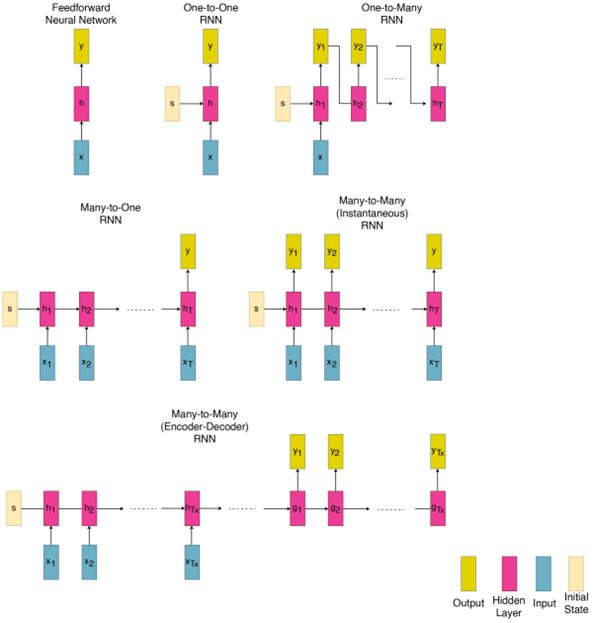

The following diagram shows the structure of an RNN in both time-folded and time-unfolded forms:

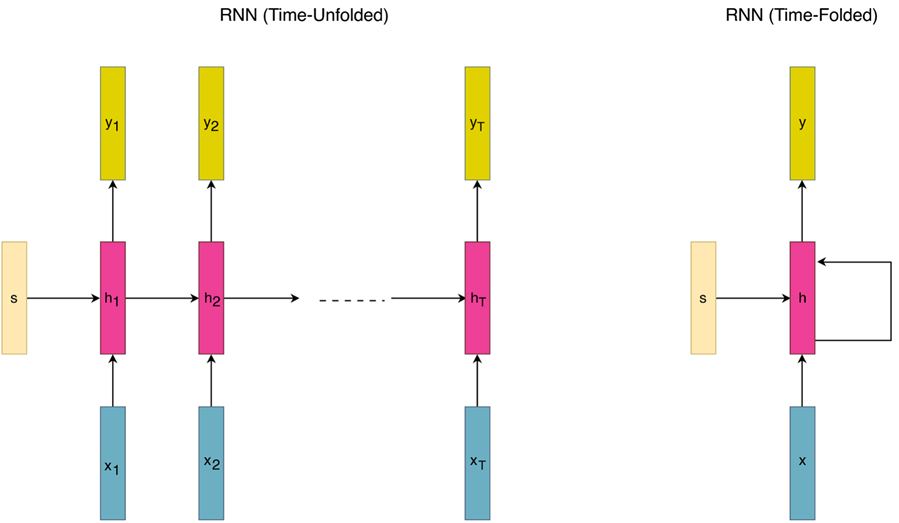

One of the powerful features of RNNs is that they can deal with sequential data of varying sequence lengths (T). One way of dealing with this variability in length is by padding shorter sequences and truncating longer sequences, as we will see in the exercises provided later in this chapter.

### RNNs

The idea behind RNNs became evident with the emergence of the Hopfield network in 1982, which is a special type of RNN that tries to emulate the workings of human memory. RNNs later came into their own existence based on the works of David Rumelhart, among others, in 1986. These RNNs were able to process sequences with an underlying concept of memory. From here, a series of improvements were made to its architecture, as shown in the following diagram:

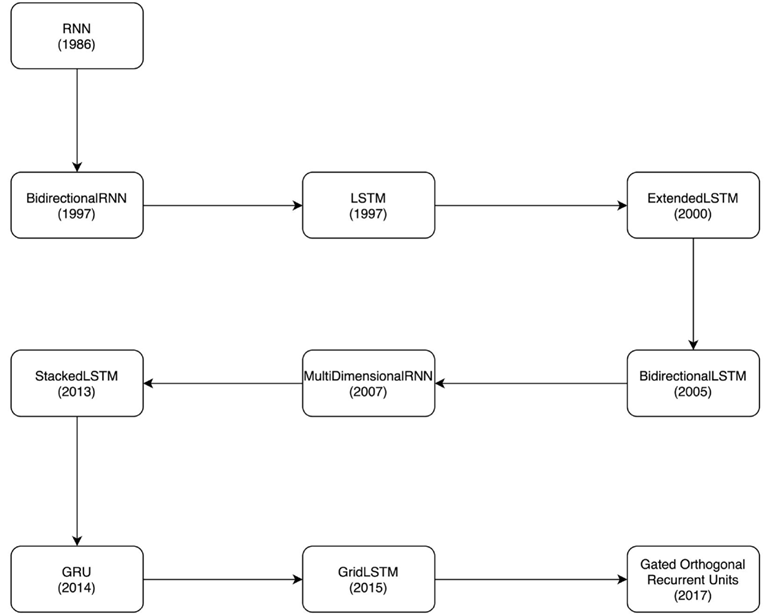

### Bidirectional RNNs

it was later realized that some sequence-related tasks, such as language translation, can be done more efficiently by looking at both past and future information.

These are pretty similar to conventional RNNs except that bidirectional RNNs have two RNNs working internally: one running the sequence from start to end, and another running the sequence backward from end to start, as shown in the following diagram:

### LSTMs

While RNNs were able to deal with sequential data and remember information, they suffered from the problem of exploding and vanishing gradients. This happened because of the extremely deep networks that resulted from unfolding the recurrent networks in the time dimension.

    Normal RNNs
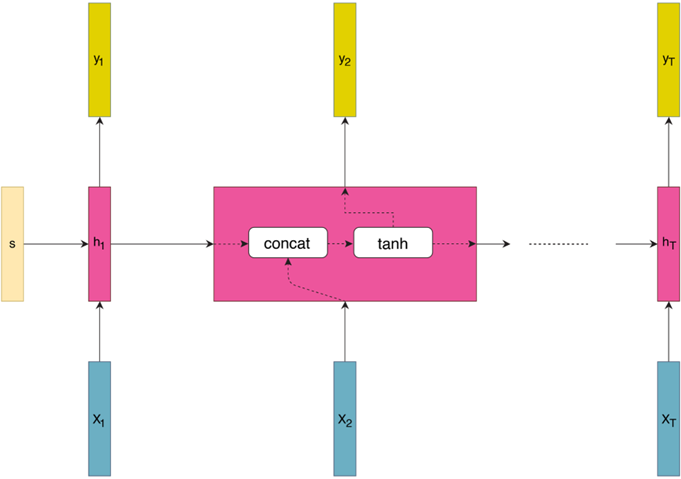

An LSTM layer essentially consists of various time-unfolded LSTM cells. Information passes from one cell to another in the form of cell states. These cell states are controlled or manipulated using multiplications and additions using the mechanism of gates. 

    LSTM
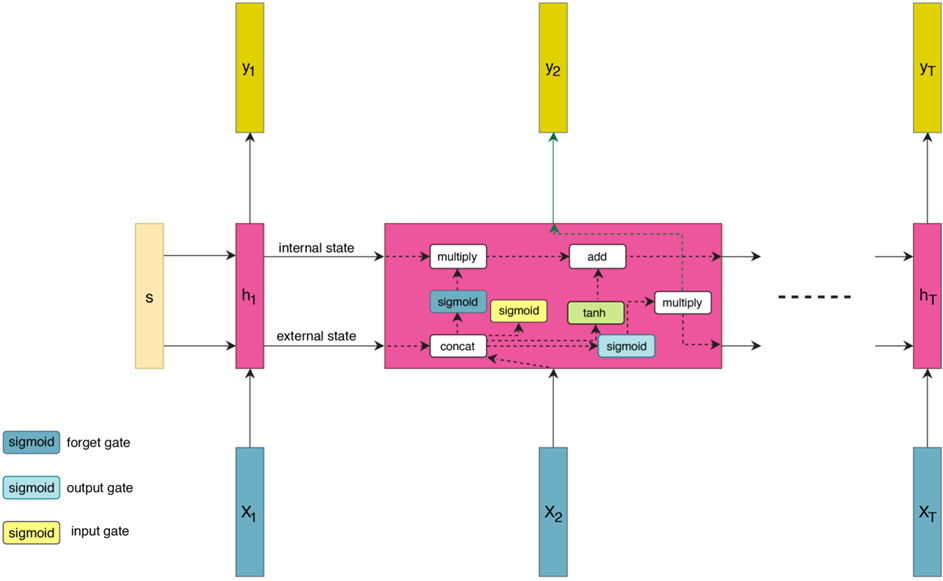

    Next, we discuss more advanced variants of LSTMs.

#### Extended and bidirectional LSTMs

#### Multi-dimensional RNNs

#### Stacked LSTMs

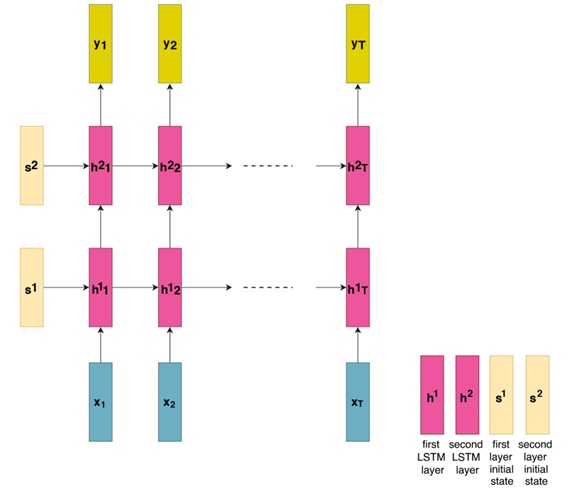

#### GRUs
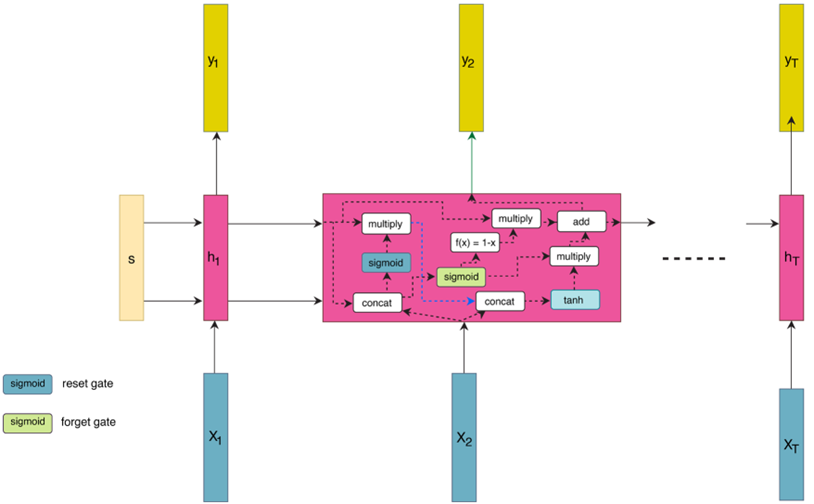

#### Grid LSTMs

#### Gated orthogonal recurrent units

## Training RNNs for sentiment analysis

### Loading and preprocessing the text dataset

#### 1. Imports

In [2]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation 
from collections import Counter 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
torch.use_deterministic_algorithms(True)

#### 2. Read the data from the text files.

    the IMDb sentiment analysis dataset 

In [ ]:
# read sentiments and reviews data from the text files
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname), encoding="utf8") as f:
            review_list += [f.read()]
            label_list += [label]
print ('Number of reviews :', len(review_list))

#### 3. Following the data loading step, we will now start processing the text data

In [ ]:
# pre-processing review text
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

# accumulate all review texts together
reviews_blob = ' '.join(review_list)

# generate list of all words of all reviews
review_words = reviews_blob.split()

# get the word counts
count_words = Counter(review_words)

# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(sorted_review_words[:10])

we lower-cased the entire text corpus and, subsequently, removed all punctuation marks from the review texts. Then, we accumulated all the words in all the re-views together to get word counts and sorted them in decreasing order of counts

Ideally, these non-nouns, also referred to as stop words, would be removed from the corpus as they do not carry a lot of meaning

#### 4. Converting these individual words into numbers or tokens. 
This is a crucial step because machine learning models only understand numbers, not words:

In [ ]:
# create word to integer (token) dictionary
# in order to encode text as numbers 
vocab_to_token = {word:idx+1 for idx,
                  (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

Starting with the most popular word, numbers are assigned to words 1 onward.

#### 5. We obtained the word-to-integer mapping in the previous step

    vocabulary of our dataset

we will use the vocabulary to translate movie reviews in our dataset into a list of numbers:

In [ ]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in 
                     review.split()]
    reviews_tokenized.append(word_to_token) 
print(review_list[0])
print()
print (reviews_tokenized[0])

#### 6. We shall also encode the sentiment targets – pos and neg – into numbers 1 and 0

In [ ]:
# encode sentiments as 0 or 1
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]

reviews_len = [len(review) for review in reviews_tokenized]

reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32')

#### 7. Normalize different-length reviews so that they are all the same length.

    sequence length *L* (512, in this case)

In [ ]:
def pad_sequence(reviews_tokenized, sequence_length):
    ''' returns the tokenized review sequences padded with 0's or truncated to the sequence_length.
    '''
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length-review_len))
            new_sequence = zeroes+review
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]
        
        padded_reviews[idx,:] = np.array(new_sequence)
    
    return padded_reviews

In [ ]:
sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)

plt.hist(reviews_len)

#### 8. Split our dataset into training and validation sets with a 75:25 ratio:

In [ ]:
train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

#### 9. At this stage, we can start using PyTorch to generate the dataset and dataloader objects from the processed data:

In [ ]:
# generate torch datasets
train_dataset = TensorDataset( 
    torch.from_numpy(train_X).to(device),
    torch.from_numpy(train_y).to(device)) 
validation_dataset = TensorDataset(
    torch.from_numpy(validation_X).to(device), 
    torch.from_numpy(validation_y).to(device))
batch_size = 32
# torch dataloaders (shuffle data) 
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True) 
validation_dataloader = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=True)

#### 10. To get a feeling of what the data looks like before we feed it to the model, let’s visualize a batch of 32 reviews and the corresponding sentiment labels:

In [ ]:
# get a batch of train data
train_data_iter = iter(train_dataloader)
X_example, y_example = next(train_data_iter)
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

### Instantiating and training the model

    PyTorch makes it incredibly compact through its nn�RNN module to instantiate the RNN layer. 

    embedding layer + RNN layer

    The model has 512 layers in the time dimension and Depth of 32

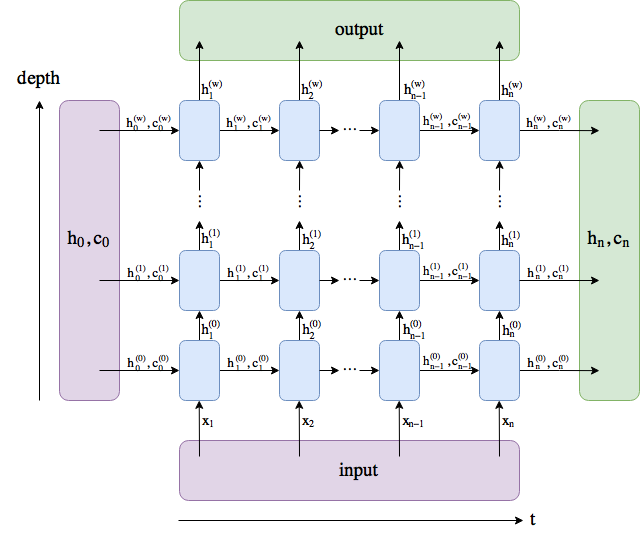

#### 1. Define RNN

For example, the word it, which is tokenized as number 8 in our vocabulary, will be stored as a vector of size 100 at the 8th row in this lookup table. You can initialize the embeddings lookup table with pre-trained embeddings for better performance, but we will be training it from scratch in this exercise.

In [13]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)  
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
        
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)  
        # embedding shape = [sequence_length, batch_size, embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
        # output shape = [sequence_length, batch_size, hidden_dimension]
        # hidden_state shape = [1, batch_size, hidden_dimension]
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))      
        return final_output

In [10]:
# input_dimension = len(vocab_to_token)+1 # +1 to account for padding
input_dimension = 10000 + 1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

In [11]:
total_params = sum(p.numel() for p in rnn_model.parameters())

In [12]:
for p in rnn_model.parameters():
    print(p.numel())

3200
1024
32
32
32
1


#### 2. In the following code, we are instantiating the RNN model:

In [ ]:
input_dimension = len(vocab_to_token)+1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

#### 3. We will also define an accuracy metric to measure the performance of our trained model on the validation set. We will be using simple 0-1 accuracy for this exercise:

In [ ]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float() #convert into float for division 
    accuracy = success.sum() / len(success)
    return accuracy

#### 4. Define the training and validation routines.

In [ ]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    
    for sequence, sentiment in dataloader:
        optim.zero_grad()     
        preds = model(sequence.T).squeeze()
        
        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_metric(preds, sentiment)
        
        loss_curr.backward()
        optim.step()
        
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [ ]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            
            preds = model(sequence.T).squeeze()
            
            loss_curr = loss_func(preds, sentiment)   
            accuracy_curr = accuracy_metric(preds, sentiment)

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

#### 5. Train the model

In [ ]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

    time_start = time.time()
    
    training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)
    
    time_end = time.time()
    time_delta = time_end - time_start  
    
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()

#### 6. Define helper function to make a real-time inference on the trained model:

In [ ]:
def sentiment_inference(model, sentence):
    model.eval()
    
    # text transformations
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant')
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))
    
    return pred.item()

#### 7. Test the performance of this model on some manually entered review texts:

In [ ]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I just really loved the movie"))

## Building a bidirectional LSTM

### Loading and preprocessing the text dataset

we will demonstrate the power of PyTorch’s torchtext module.

Instead of manually downloading the dataset, we will use the pre-existing IMDb dataset under torchtext.legacy.datasets to load it. We will also use torchtext.legacy.data to tokenize words and generate vocabulary.

Please note that torchtext.legacy is not supported by PyTorch V2, and hence we are using V1.9 for this exercise. The code for this exercise can be found in our GitHub repository [4]. Let’s get started:

**จะไม่ทำเนื้อหาตรงนี้เพราะเป็นการใช้ torch version 1.9**

## Discussing GRUs and attention-based models

### GRUs and PyTorch

GRUs are simpler than LSTMs and yet equally effective in dealing with the exploding and vanishing gradients problem. 

    one is slightly better than the other on some tasks and vice versa.

GRUs train faster than LSTMs, and on many tasks such as language modeling, GRUs can perform as well as LSTMs with much less training data. However, theoretically, LSTMs are supposed to retain information from longer sequences than GRUs. PyTorch provides the **nn.GRU** module to instantiate a GRU layer in one line of code. 

### Attention-based models

Attention-based recurrent networks were the first ones to exploit the concept of attention around the years 2014-2015.

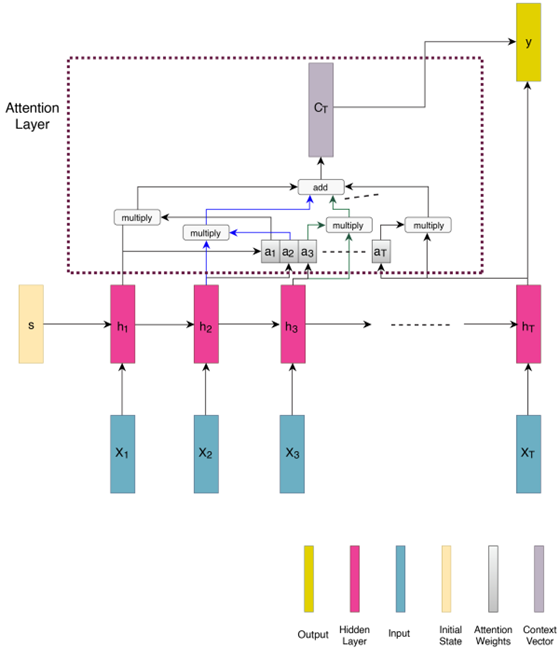

Attention-based RNNs outperformed the state-of-the-art recurrent models on ?tasks such as machine translation.

    A couple of years later, in 2017, the Attention Is All You Need paper demonstrated the ability to solve sequential tasks solely with the use of an attention mechanism without requiring the recurrent layers. 

    Recurrent networks need to be unrolled in time, which makes them non-parallelizable. However, a new model called the transformer model, which we will discuss in the next chapter, has no recurrent (and convolutional) layers, making it both parallelizable and lightweight (in terms of computation flops).